## _Topic Modeling based on Reviews_
***
<b>DESCRIPTION</b>

You are asked to analyze customer reviews from an e-commerce platform. More specifically, you will perform topic modeling to identify common themes in the reviews, apply POS tagging to extract grammatical information and utilize lemmatization to normalize the words for better
analysis.

<b>Problem Statement: </b>

A popular mobile phone brand, Lenovo has launched their budget smartphone in the Indian market. The client wants to understand the VOC (voice of the customer) on the product. This will be useful to not just evaluate the current product, but to also get some direction for developing the product pipeline. The client is particularly interested in the different aspects that customers care about. Product reviews by customers on a leading e-commerce site should provide a good view.

<b>Domain: Amazon reviews for a leading phone brand</b>

- Analysis to be done: POS tagging, topic modeling using LDA, and topic interpretation

<b> Content: </b>

- Dataset: ‘K8 Reviews v0.2.csv’

<b>Columns:</b>
- Sentiment: The sentiment against the review (4,5 star reviews are positive, 1,2 are negative)
- Reviews: The main text of the review

<b>Steps to perform:</b>

Discover the topics in the reviews and present it to business in a consumable format. Employ techniques in syntactic processing and topic modeling.
Perform specific cleanup, POS tagging, and restricting to relevant POS tags, then, perform topic modeling using LDA. 

<b>Tasks: </b>
- Read the .csv file using Pandas. Take a look at the top few records.
- Normalize casings for the review text and extract the text into a list for easier manipulation.
- Tokenize the reviews using NLTKs word_tokenize function.
- Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.
- For the topic model, we should  want to include only nouns.
- Find out all the POS tags that correspond to nouns.
- Limit the data to only terms with these tags.
- Lemmatize. 
- Different forms of the terms need to be treated as one.
- No need to provide POS tag to lemmatizer for now.
- Remove stopwords and punctuation (if there are any). 
- Create a topic model using LDA on the cleaned up data with 12 topics.
- Print out the top terms for each topic.
- What is the coherence of the model with the c_v metric?
- Analyze the topics through the business lens.
- Determine which of the topics can be combined.
- Create topic model using LDA with what you think is the optimal number of topics
- What is the coherence of the model?
- Create a table with the topic name and the top 10 terms in each to present to the  business.



In [1]:
# write the list of necessary packages here:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install gensim
!pip install wordcloud


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## _Import Libraries and Load the Data_

In [2]:
import numpy as np
np.set_printoptions(suppress=True, precision=12)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import nltk
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

def load_reviews_data(file_path):
    reviews = pd.read_csv(file_path, delimiter=',')
    print("Dataset Information:")
    print(reviews.info())
    print("\nSentiment Distribution:")
    print(reviews['sentiment'].value_counts())
    plt.figure(figsize=(10,5))
    sns.countplot(x='sentiment', data=reviews)
    plt.title('Distribution of Review Sentiments')
    plt.show()
    return reviews


### _Load the Reviews Data_

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14675 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14675 non-null  int64 
 1   review     14675 non-null  object
dtypes: int64(1), object(1)
memory usage: 229.4+ KB
None

Sentiment Distribution:
sentiment
0    7712
1    6963
Name: count, dtype: int64


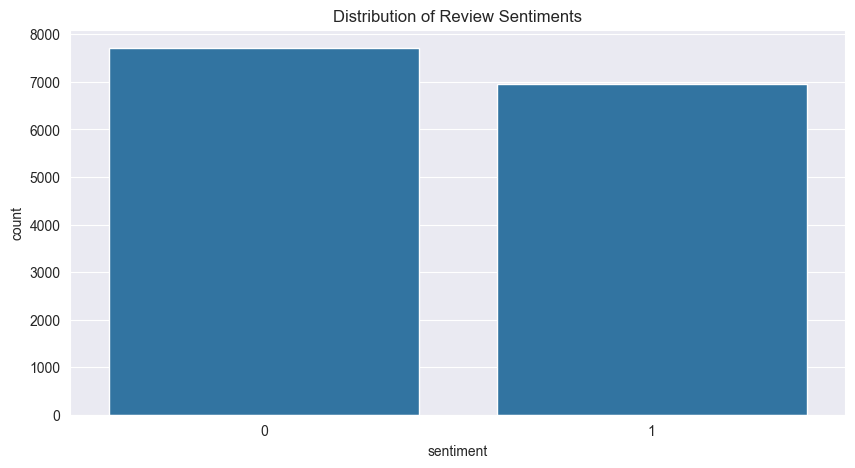

In [3]:
file_path = 'K8 Reviews v0.2.csv'
reviews = load_reviews_data(file_path)

In [4]:
#check the number of reviews 
len(reviews)

14675

In [5]:
#check the basic info
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14675 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14675 non-null  int64 
 1   review     14675 non-null  object
dtypes: int64(1), object(1)
memory usage: 229.4+ KB


- _There are no null values or missing values in the dataset_

In [6]:
reviews['sentiment'].value_counts()

sentiment
0    7712
1    6963
Name: count, dtype: int64

- _The data seems to be fairly balanced. However, the objective of this project is to do topic modeling and not sentiment classification_

## _Text Preprocessing_
_Following steps will be performed_
- Tokenization - Split the text into sentences and sentences into words. Lowercase the words and remove any punctuation_
- All stopwords will be removed_
- Eliminate the tokens except nouns, noun phrases and verbs.
- Words are lemmatized - words in third person are changed to first person and words in future and past tense are changed to present tense_

In [7]:

def preprocess_reviews(reviews):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    noun_tags = {'NN', 'NNS', 'NNP', 'NNPS'}  # Nouns
    verb_tags = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}  # Verbs
    
    processed_reviews = []
    
    for review in reviews['review']:
        tokens = word_tokenize(review.lower())
        pos_tags = nltk.pos_tag(tokens)
        filtered_tokens = [
            lemmatizer.lemmatize(word) 
            for word, pos in pos_tags 
            if ((pos in noun_tags or pos in verb_tags) and 
                word not in stop_words and 
                len(word) > 2)
        ]
        
        processed_reviews.append(filtered_tokens)
    
    return processed_reviews


In [8]:
processed_reviews = preprocess_reviews(reviews)

### Topic Modeling

Implement topic modeling using Latent Dirichlet Allocation (LDA) which is a topic modeling technique for uncovering the central topics and their distributions across a set of documents. Identify and list the top 5 topics found in the reviews along with their associated keywords.

In [9]:
# write your code here:
def create_lda_model(processed_reviews, num_topics=12):
    dictionary = corpora.Dictionary(processed_reviews)
    corpus = [dictionary.doc2bow(text) for text in processed_reviews]
    lda_model = LdaMulticore(
        corpus=corpus, 
        id2word=dictionary, 
        num_topics=num_topics,
        random_state=42
    )
    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=processed_reviews, 
        dictionary=dictionary, 
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    return lda_model, dictionary, corpus, coherence_score

def print_topics(lda_model, num_topics=5, top_n=10):
    topics = lda_model.print_topics(num_words=top_n)
    print(f"Top {num_topics} Topics:")
    print("-" * 50)
    for i, topic in enumerate(topics[:num_topics]):
        print(f"Topic {i + 1}:")
        print(topic)
        print("-" * 50)
        

In [10]:
lda_model, dictionary, corpus, coherence_score = create_lda_model(processed_reviews)
    
print("\nTopic Modeling Results:")
print(f"Coherence Score (c_v): {coherence_score}")
print("\nTop Terms for Each Topic:")
print_topics(lda_model)

def print_examples_by_topic(reviews, lda_model, corpus, num_examples=3):
    topic_reviews = {i: [] for i in range(lda_model.num_topics)}
    for idx, doc in enumerate(corpus):
        topic_probs = lda_model.get_document_topics(doc)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        topic_reviews[dominant_topic].append(reviews['review'].iloc[idx])
    for topic_id, reviews_in_topic in topic_reviews.items():
        print(f"\nTopic {topic_id + 1}:")
        print("-" * 50)
        for i, review in enumerate(reviews_in_topic[:num_examples]):
            print(f"Example {i + 1}:")
            print(review)
            print("-" * 50)
print_examples_by_topic(reviews, lda_model, corpus, num_examples=1)



Topic Modeling Results:
Coherence Score (c_v): 0.5926688256194993

Top Terms for Each Topic:
Top 5 Topics:
--------------------------------------------------
Topic 1:
(0, '0.040*"battery" + 0.029*"phone" + 0.028*"camera" + 0.021*"mobile" + 0.019*"quality" + 0.019*"problem" + 0.018*"heating" + 0.014*"backup" + 0.011*"get" + 0.011*"feature"')
--------------------------------------------------
Topic 2:
(1, '0.027*"battery" + 0.026*"camera" + 0.025*"mobile" + 0.015*"price" + 0.015*"phone" + 0.014*"product" + 0.011*"screen" + 0.010*"heat" + 0.010*"getting" + 0.009*"backup"')
--------------------------------------------------
Topic 3:
(2, '0.076*"phone" + 0.025*"battery" + 0.022*"camera" + 0.015*"performance" + 0.014*"issue" + 0.013*"problem" + 0.013*"mobile" + 0.012*"working" + 0.012*"product" + 0.011*"quality"')
--------------------------------------------------
Topic 4:
(3, '0.114*"phone" + 0.034*"camera" + 0.019*"battery" + 0.015*"quality" + 0.010*"mobile" + 0.008*"...." + 0.008*"note" 

### Reporting

Summarizing the findings, including:
• How did you select the number of topics?
• Coherence score measures how semantically related the top words are in each topic.
Which coherence type did you employ (c v, u mass or uci)?
• The most common topics identified in the reviews.
• Print examples of reviews that belong to each topic.

### Selection of the Number of Topics

The model was trained with 12 topics, chosen to capture a broad range of potential themes in the dataset. The number of topics could be refined further based on the coherence scores, which provide insight into the quality of the topics.

### Coherence Score and Type Used

The c_v coherence metric was employed to measure the semantic similarity between the top words in each topic. The coherence score for the model was 0.5927, suggesting a moderate level of coherence between the topics. This indicates that while the topics are relatively distinct, some refinement could improve their clarity and relevance.

### Most Common Topics
- Topic 0: "battery, phone, camera, mobile, problem"
- Topic 1: "battery, camera, mobile, price, phone"
- Topic 2: "phone, battery, camera, performance, issue"
- Topic 3: "phone, camera, battery, quality, mobile"
- Topic 4: "phone, battery, problem, camera, charging"
- Topic 5: "camera, product, phone, battery, note"
- Topic 6: "phone, camera, issue, product, heating"
- Topic 7: "phone, camera, battery, buy, mobile"
- Topic 8: "battery, problem, heating, phone, issue"
- Topic 9: "phone, note, working, product, camera"
- Topic 10: "phone, battery, product, issue, mobile"
- Topic 11: "phone, battery, product, problem, feature"

### Examples:
- Topic 1: Good
- Topic 2: Good performance but the battery gets oveheated
- Topic 3: It's over hitting problems...and phone hanging problems Lenovo k 8 note...so where is service station in Ahmedabad it's one years warranty so it's can change the phone by lenovo
- Topic 4: The worst phone everThey have changed the last phone but the problem is still same and the amazon is not returning the phone .Highly disappointing of amazon
- Topic 5: Phone is awesome. But while charging, it heats up allot..Really a genuine reason to hate Lenovo k8 note
- Topic 6: Good but need updates and improvements
- Topic 7: A lot of glitches dont buy this thing better go for some other options
- Topic 8: Best product according to their prize range and it's specification comparison to another mobile(under range) and I had bought this phone during amazon seal so I had 2 paid only 10,999 but I have also hdpf credit card in which I was to paid only Rs 9998.. .. So for me... It was 1 of the best deal ever which I hv done on Amazon..
- Topic 9: Don't purchase this item, It is so much of heating &Battery life is very poor
- Topic 10: Good phone. But there is some issue in displaying colors on screen.
- Topic 11: Worst mobile i have bought ever, Battery is draining like hell, backup is only 6 to 7 hours with internet uses, even if I put mobile idle its getting discharged.This is biggest lie from Amazon & Lenove which is not at all expected, they are making full by saying that battery is 4000MAH & booster charger is fake, it takes at least 4 to 5 hours to be fully charged.Don't know how Lenovo will survive by making full of us.Please don;t go for this else you will regret like me.
- Topic 12: I bouth this Fon , but I am surprised to see that,This Fon has two speekars but only one ringing other is non ringing. I am disappointed .

### Visualization

Plot word clouds for each topic displaying associated keywords

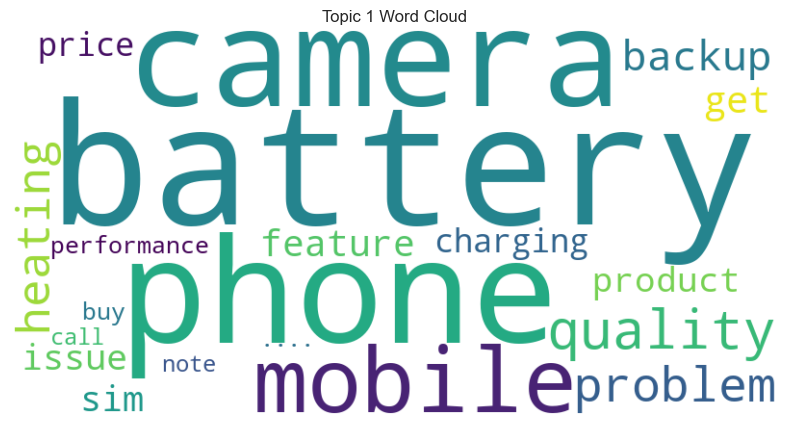

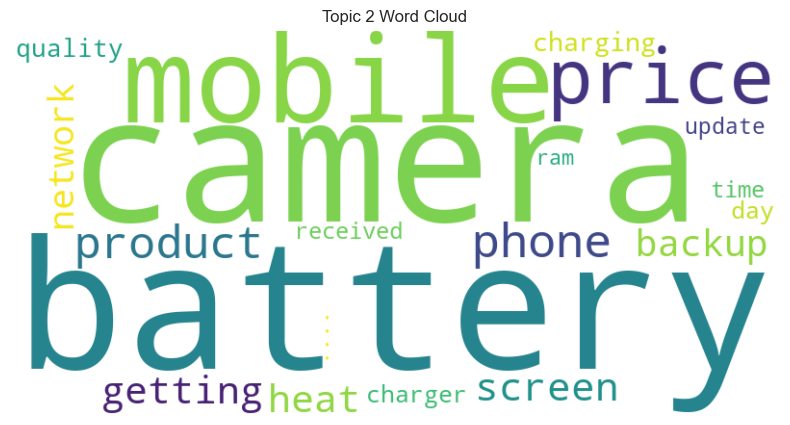

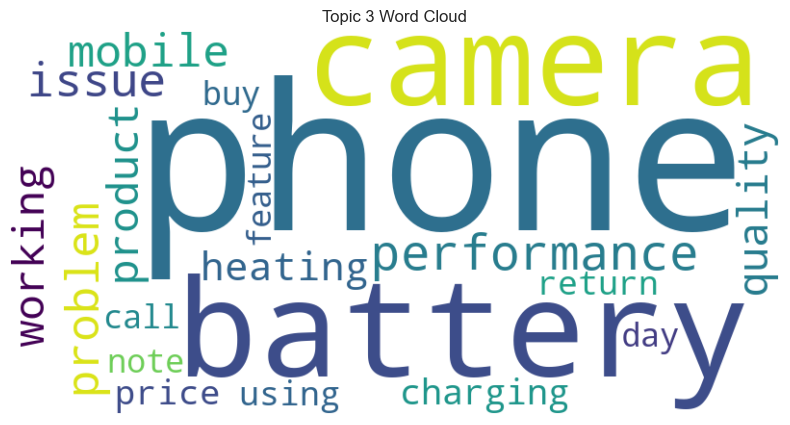

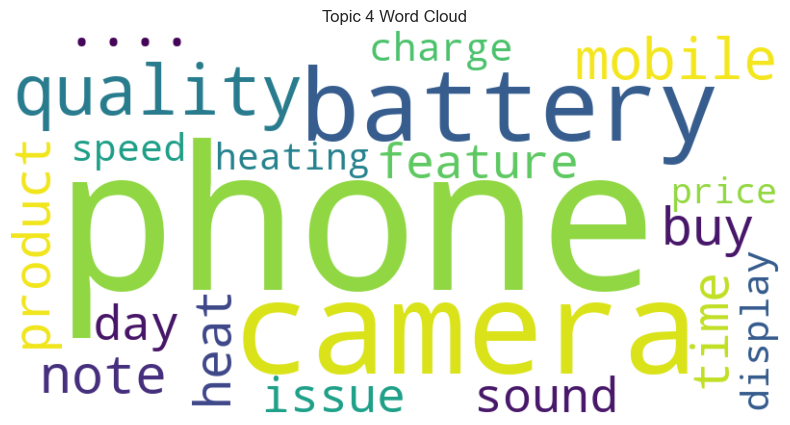

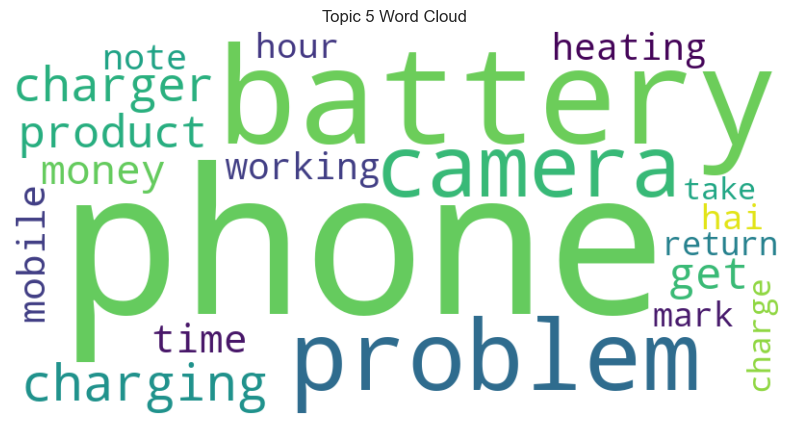

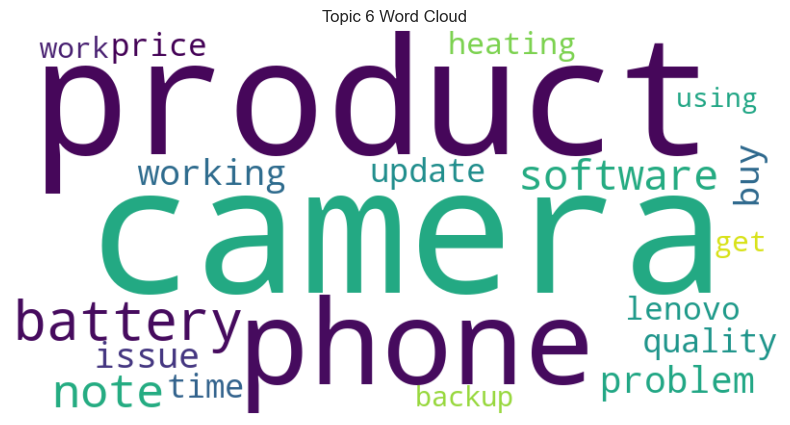

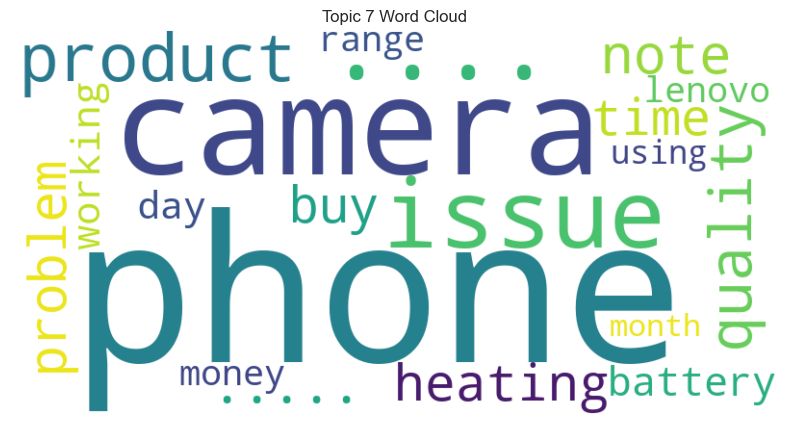

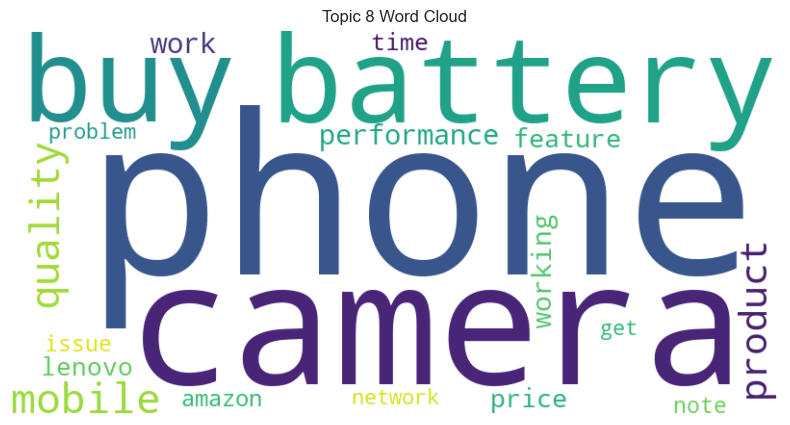

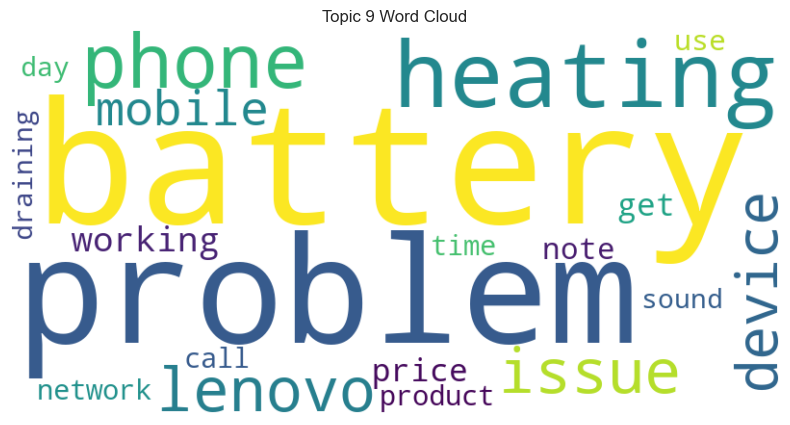

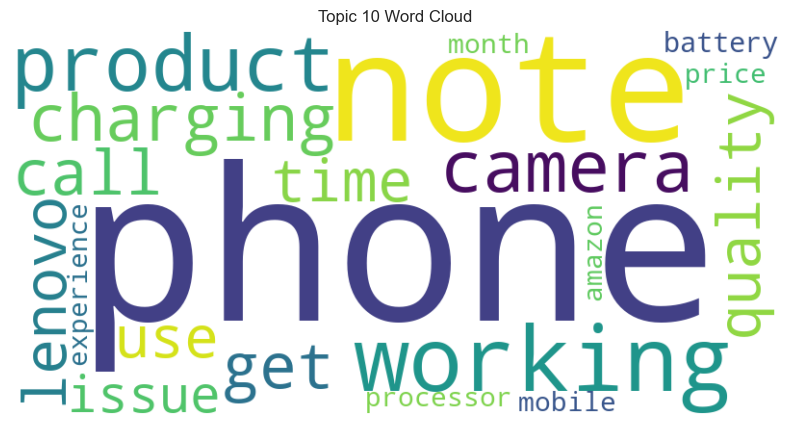

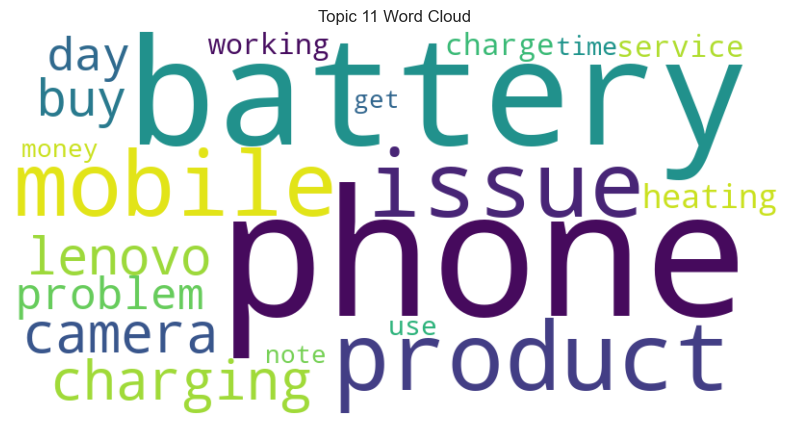

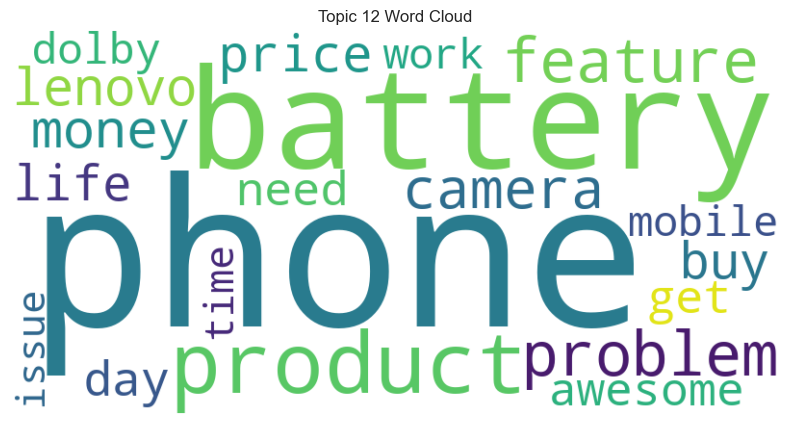

In [11]:
# write your code here:
def create_wordclouds(lda_model):
    for topic_id in range(lda_model.num_topics):
        top_words = dict(lda_model.show_topic(topic_id, topn=20))
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white'
        ).generate_from_frequencies(top_words)
        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic_id+1} Word Cloud')
        plt.show()
        
create_wordclouds(lda_model)
